In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

torch.cuda.is_available()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Torch running on:', device)

Torch running on: cuda:0


## DataLoaders

In [2]:
# load data in numpy
def load_turbo2D_simple_numpy(path_to_turbo2D, ds=4, img=42):
    """
    ds : down-scaling factor (1 = nothing, 2=every 2 samples, ...)
    img : index of the image (max is 55)
    
    returns: 
        X flatten coordinate grid (R^2)x2
        y flatten target velocity field (R^2)x2
    """
    
    assert img < 55

    IMGs = np.load(path_to_turbo2D)
    img = img
    X = IMGs[img,::ds,::ds,:2] / 255
    U = IMGs[img,::ds,::ds,2:]

    # normalize output
    y = U.copy()
    print('Y shape', y.shape)
    print('Y min, max:', np.min(y), np.max(y))
    y = y / np.max(np.abs(y))
    print('after normalization, Y min, max:', np.min(y), np.max(y))

    X = X.reshape(-1,2)
    y = y.reshape(-1,2)

    assert X.shape == y.shape

    return X, y


class Turbo2D_simple(Dataset):
    
    def __init__(self, path_to_turbo2D, device, ds=4, img=42):
        
        print('Dataset Turbo2D, img #', img)

        IMGs = np.load(path_to_turbo2D)
        X = IMGs[img,::ds,::ds,:2] / 255
        U = IMGs[img,::ds,::ds,2:]

        print(X.shape)
        print(U.shape)

        original_size = X.shape[0]
        print('Original size', original_size)

        # normalize output
        y = U.copy()
        print('Y shape', y.shape)
        print('Y min, max:', np.min(y), np.max(y))
        y = y / np.max(np.abs(y))
        
        print('after normalization, Y min, max:', np.min(y), np.max(y))

        self.x = torch.from_numpy(X).float().to(device).view(-1,2)
        self.y = torch.from_numpy(y).float().to(device).view(-1,2)

        assert self.x.shape[0] == self.y.shape[0]

    
    def __len__(self):
        return self.x.shape[0]
    

    def __getitem__(self, idx):
        x = self.x[idx,:]
        y = self.y[idx,:]
        return (x, y)
    

*optional*: load groundtruth data in numpy.

This might be usefull for plotting

In [3]:
path_to_turbo2D = '../data/2021-Turb2D_velocities.npy'
img_idx = 42

# optional: load groundtruth data in numpy.
#           usefull for plotting
Xlr, ulr = load_turbo2D_simple_numpy(path_to_turbo2D, ds=4, img=img_idx) # LR data
Xhr, uhr = load_turbo2D_simple_numpy(path_to_turbo2D, ds=1, img=img_idx) # HR data

L = int(Xlr.shape[0]**0.5)
H = int(Xhr.shape[0]**0.5)

print('Img res:', L, 'Input batch:', Xlr.shape) # LR data
print('Img res:', H, 'Input batch:', Xhr.shape) # HR data

Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0
Y shape (256, 256, 2)
Y min, max: -2.382122 2.999472
after normalization, Y min, max: -0.7941804424245333 1.0
Img res: 64 Input batch: (4096, 2)
Img res: 256 Input batch: (65536, 2)


training data in pytorch dataset

In [4]:
trainset = Turbo2D_simple(path_to_turbo2D, device, ds=4, img=42)
trainloader = DataLoader(trainset, batch_size=6666, shuffle=False)

Dataset Turbo2D, img # 42
(64, 64, 2)
(64, 64, 2)
Original size 64
Y shape (64, 64, 2)
Y min, max: -2.365612 2.941536
after normalization, Y min, max: -0.8042097733972999 1.0


# Basics building block of our model

In [5]:
class Fourier(nn.Module):
    """
    Compute Random Fourier Features:
        sin(2*pi*B*x) and cos(2*pi*B*x)
        B : matrix n_featuresx2
        x : input vector n_batchx2        
    """
    
    def __init__(self, nfeat, scale):
        super(Fourier, self).__init__()
        self.b = nn.Parameter(torch.randn(2, nfeat)*scale, requires_grad=False)
        self.pi = 3.14159265359 # better to hardcode this, rather than use np.pi

    def forward(self, x):
        x = torch.einsum('bc,cf->bf', 2*self.pi*x, self.b.to(x.device))
        return torch.cat([torch.sin(x), torch.cos(x)], -1)

    
def LinearReLU(n_in, n_out):
    """
    Simple block Linear + ReLU
    """
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.ReLU()
    )
    return block


def LinearTanh(n_in, n_out):
    """
    Simple block Linear + Tanh
    # Tanh is C^\infty and it may be better when computing high order derivates
    """
    block = nn.Sequential(
      nn.Linear(n_in, n_out),
      nn.Tanh()
    )
    return block

In [6]:
class MLP(nn.Module):
    """
    Simple MLP
        - dim_layes in a list [Nin] + [H_1] + [...] + [Nout]:
            e.g. [2] + 3*[256] + [2]
        - last_activation_fun : a nn.Module
            e.g. nn.Tanh(), nn.Sigmoid(), or nn.ReLU()
    """
    
    def __init__(self, dim_layers):
        super(MLP, self).__init__()
        layers = []
        num_layers = len(dim_layers)
        
        blocks = []
        for l in range(num_layers-2):
            blocks.append(LinearTanh(dim_layers[l], dim_layers[l+1]))
            
        blocks.append(nn.Linear(dim_layers[-2], dim_layers[-1]))
        blocks.append(nn.Sigmoid())
        self.network = nn.Sequential(*blocks)
    
    def forward(self, x):
        return self.network(x)

In [19]:
class DivFreeKernel(nn.Module):
    """
    Given a Radial Basis Function $\psi(x)$, the matrix-valued RBFs $\Phi(x)$ in which
    the vector fields defined by the columns are divergence-free is constructed as follows
            $\Phi_df(x) = (\nabla \nabla^T - \nabla^2 I)\psi(x)$ (1).
    
    In the 2D case and assuming that our MLP ~ RBFs (***STRONG ASSUMPTION HERE***), we can compute our vector field as follows.
    
    $\Phi_df(x) = ( [ d/dxx   d/dxy  ] - [d/dxx + d/dyy           0        ] ) MLP(x)
                  ( [ d/dyx   d/dyy  ] - [      0           d/dxx + d/dyy  ] )
                
                = ( [ -d/dyy    d/dxy  ]) Phi(x)
                  ( [  d/dyx   -d/dxx  ])
    
    u = -dMLP(x)/dyy + dMLP(x)/dxy
    v =  dMLP(x)/dxy - dMLP(x)/dxx
    
    
    References:
        - [Macedo et Casto,  2010](https://www.yumpu.com/en/document/read/37810994/learning-divergence-free-and-curl-free-vector-fields-with-matrix-)
        - [Colin P. McNally, 2011](https://arxiv.org/pdf/1102.4852.pdf)
    """
    
    def __init__(self):
        super(DivFreeKernel, self).__init__()
        pass
    
    def forward(self, y, x):
        
        # compute first order deriv
        dy_xy = torch.autograd.grad(y, x, torch.ones_like(y), 
                                    create_graph=True,
                                    retain_graph=True)[0]
        # separate x and y components
        dy_x, dy_y = dy_xy.split(1,-1)
        
        # compute secord order deriv wrt to x
        dy_x_xy = torch.autograd.grad(dy_x, x, torch.ones_like(dy_x), 
                                      create_graph=True,
                                      retain_graph=True)[0]
        # compute secord order deriv wrt to y
        dy_y_xy = torch.autograd.grad(dy_y, x, torch.ones_like(dy_y),
                                      create_graph=True,
                                      retain_graph=True)[0]
        
        dy_xx, dy_xy = dy_x_xy.split(1,-1)
        dy_yx, dy_yy = dy_y_xy.split(1,-1)

        # gather results in a matrix Bx2x2 in the form of Div-free kernel
        # K1 = torch.cat([-dy_yy, dy_xy], dim=-1)[...,None]
        # K2 = torch.cat([dy_yx, -dy_xx], dim=-1)[...,None]
        # K = torch.cat([K1, K2], dim=-1)
        # the columns of K make a divergence-free field
        u =  dy_xy - dy_yy
        v =  dy_xy - dy_xx
        
        u = torch.cat([u,v], dim=-1)
        return u
        

Putting all the blocks together

In [21]:
class DivFreeRFFNet(nn.Module):
    
    def __init__(self, name, 
                    dim_mpl_layers,
                    do_rff, f_nfeatures, f_scale, lam_pde=1, 
                    verbose=True):
        
        super(DivFreeRFFNet, self).__init__()
        self.name = name
        self.verbose = verbose

        assert dim_mpl_layers[-1] == 1
        
        # regression/pinn network 
        self.do_rff = do_rff
        if do_rff:
            self.rff = Fourier(f_nfeatures, f_scale) # directly the random matrix 'cause of checkpoint and load
            dim_mpl_layers[0] = dim_mpl_layers[0]*f_nfeatures
            self.rff = Fourier(f_nfeatures, f_scale)

        self.mlp = MLP(dim_mpl_layers)
        self.div = DivFreeKernel()
        
        self.lam_pde = lam_pde # regularizer for divergence solft constraint

        # for log of the losses
        self.loss = []
        self.loss_pde = []
        self.loss_rec = []
        
        
    def forward(self, xin): # x := BxC(Batch, InputChannels)
        
        xin.requires_grad_(True)
        
        ## Fourier features
        if self.do_rff:
            x = self.rff(xin) # Batch x Fourier Features
            ## MLP
            x = self.mlp(x)
        else:
            ## MLP
            x = self.mlp(xin)
            
        # at this point x in the potential
        potential = x
        
        # divergence free
        div_free_uv = self.div(x, xin)
        
        return div_free_uv, potential
    
    def compute_ux(self, xin):
        xin.requires_grad_(True)
        y, Py = self.forward(xin)
        du_xy = torch.autograd.grad(Py, xin, torch.ones_like(Py), create_graph=True)[0]       
        return du_xy

    def fit(self, trainloader, epochs=1000):
        self.train()
        optimiser = torch.optim.Adam(self.parameters(), lr=1e-4)
        epoch = 0
        while epoch < epochs or loss < 1e-6:
            epoch += 1
            current_loss = 0
            batches = 0
            for x_batch, y_batch in trainloader:
                batches += 1
                optimiser.zero_grad()
                
                # FORWARD
                y_hat, potential_hat = self.forward(x_batch)
                
                # LOSS
                loss_rec = (1/batches)*F.mse_loss(y_hat, y_batch)
                
                # check div=0
                u, v = torch.split(y_hat,1,-1)
                du_xy = torch.autograd.grad(u, x_batch, torch.ones_like(u), create_graph=True)[0]       
                dv_xy = torch.autograd.grad(v, x_batch, torch.ones_like(v), create_graph=True)[0]
                div_u_xy = du_xy[...,0] + dv_xy[...,1]
                loss_pde = (1/batches)*torch.norm(div_u_xy)**2
            
                # the network is div-free by construction,
                # so we optimize against the loss_rec only.
                # We compute loss_pde for logging
                loss = loss_rec # + self.lam_pde*loss_pde
                current_loss +=  loss.item() - current_loss

                self.loss_rec.append(loss_rec.item())
                self.loss_pde.append(self.lam_pde*loss_pde.item())

                # BACKWARD
                loss.backward()
                optimiser.step()
                
                # LOG
                if self.verbose and (epoch % 100 == 0 or epoch == 1):
                    print('Epoch: %4d, Loss: (rec: [%f] + %1.2f * div-free: [%f]) = %f' %
                     (epoch, loss_rec.item(), self.lam_pde, loss_pde.item(), current_loss))

        print('Done with Training')
        print('Final error:', current_loss)

MLP + DivFree(autograd)  --- no RFF

In [22]:
def to_numpy(x):
    return x.detach().cpu().numpy()

def to_torch(x):
    return torch.from_numpy(x).float().to(device)

In [25]:
# model (RFF + MLP)
do_rff = True   # <--------
fft_scale = 10  # <--------
fft_nfeat = 256 # <--------

nin = 2  # = x and y coordinates
nout = 1 # = in the mlp we predict the potential, ux and uy components followed
mlp_layers = [nin] + [256]*3 + [nout] # if do_rff, the first layer is 2*n_features, but this is already handled by the class construction

model = DivFreeRFFNet('DivFreeNet_RFF', mlp_layers,
                      do_rff, fft_nfeat, fft_scale, verbose=True)

# TRAIN!
model.to(device)
model.fit(trainloader, epochs=5000) # we are not afraid to overfit the data, this is coord-based MLP!

Epoch:    1, Loss: (rec: [12782.241211] + 1.00 * div-free: [0.048975]) = 12782.241211
Epoch:  100, Loss: (rec: [41.071991] + 1.00 * div-free: [0.003628]) = 41.071991
Epoch:  200, Loss: (rec: [15.236067] + 1.00 * div-free: [0.002762]) = 15.236067
Epoch:  300, Loss: (rec: [8.211402] + 1.00 * div-free: [0.002397]) = 8.211402
Epoch:  400, Loss: (rec: [5.222137] + 1.00 * div-free: [0.002170]) = 5.222137
Epoch:  500, Loss: (rec: [3.610413] + 1.00 * div-free: [0.002062]) = 3.610413
Epoch:  600, Loss: (rec: [2.610224] + 1.00 * div-free: [0.001951]) = 2.610224
Epoch:  700, Loss: (rec: [1.936741] + 1.00 * div-free: [0.001896]) = 1.936741
Epoch:  800, Loss: (rec: [1.460704] + 1.00 * div-free: [0.001805]) = 1.460704
Epoch:  900, Loss: (rec: [1.113811] + 1.00 * div-free: [0.001796]) = 1.113811
Epoch: 1000, Loss: (rec: [0.855843] + 1.00 * div-free: [0.001763]) = 0.855843
Epoch: 1100, Loss: (rec: [0.661266] + 1.00 * div-free: [0.001765]) = 0.661266
Epoch: 1200, Loss: (rec: [0.512992] + 1.00 * div-fre

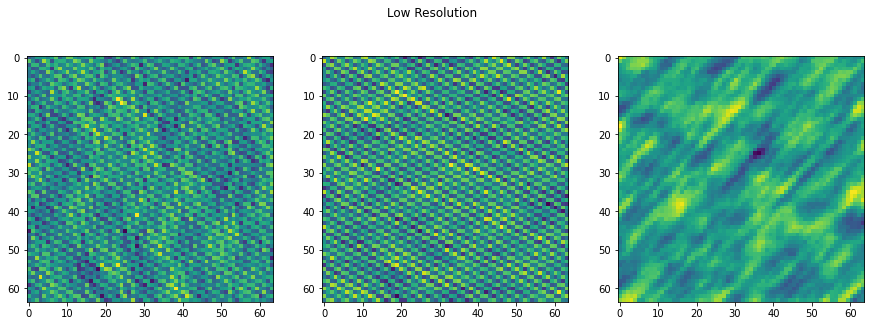

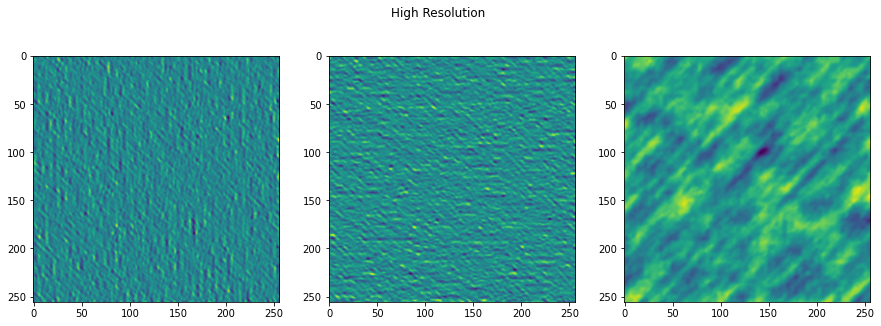

In [26]:
# TEST
model.eval().to(device)
ulr_pred, Plr_pred = model(to_torch(Xlr))
uhr_pred, Phr_pred = model(to_torch(Xhr))

ulr_pred = to_numpy(ulr_pred)
Plr_pred = to_numpy(Plr_pred)

uhr_pred = to_numpy(uhr_pred)
Phr_pred = to_numpy(Phr_pred)

# PLOT

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(ulr_pred[:,0].reshape(L,L))
plt.subplot(132)
plt.imshow(ulr_pred[:,1].reshape(L,L))
plt.subplot(133)
plt.imshow(Plr_pred.reshape(L,L))
plt.suptitle('Low Resolution')
plt.show()

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.imshow(uhr_pred[:,0].reshape(H,H))
plt.subplot(132)
plt.imshow(uhr_pred[:,1].reshape(H,H))
plt.subplot(133)
plt.imshow(Phr_pred.reshape(H,H))
plt.suptitle('High Resolution')
plt.show()